In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from empiricaldist import Pmf, Cdf
import plotly.express as ex
from plotly.subplots import make_subplots
import plotly.graph_objs as go
from imblearn.over_sampling import SMOTE

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score

from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
%matplotlib inline

# Dataset Information
This is clinical dataset used to predict whether a patient has LVO or not based on different attributes. The dataset contains 115 patients

1. record_id and id
2. age
3. **gender**
    - 0: female
    - 1: male
4. **onset**
5. onset_d_t: onset date time
6. reached_hospital: the date and time the patient reached the hospital
7. eeg_d_t: EEG date time
8. lams: LAMS score
9. nihss: NIHSS score
10. tpa: Medication given for ischemic stroke
    - 0: not give tpa 
    - 1: gives tpa
11. tpa_d_t: TPA date time
12. evt: Medication given for acute ischemic stroke
    - 0: not give evt 
    - 1: gives evt
13. evt_d_t: EVT date time
14. **images___1, images___2, images___3**
15. **core**
16. **penumbra**
17. **hi_index**
18. ct_d_t: CT scan date time
19. **diagnosis**:
20. stroke_severity: 
    - Scales from 1 (least) to 5 (most) severity 
21. **stroke**
22. **non_stroke_mimic**
23. **other_non_stroke**
24. **ischemic_location**
25. **other_location**
26. **occluded_vessel___1,..., 25**
27. **occlusion_other**
28. **h_age_side**
29. **h_age_location**
30. **maestro_complete**
31. LVO (incl. M2)
    - 0: non-LVO
    - 1: LVO
32. Notes
33. time_elapsed


In [2]:
path = 'MAESTRO_DATA.csv'
df = pd.read_csv(path)
print(df.head(5))

   record_id  id   age  gender  onset         onset_d_t  reached_hospital  \
0          1   1  49.0     2.0    1.0   2020-10-19 9:25  2020-10-19 11:04   
1          2   2  53.0     1.0    2.0  2020-10-17 12:00  2020-10-20 10:53   
2          3   3  59.0     1.0    1.0   2020-10-22 5:30  2020-10-22 13:48   
3          4   4  92.0     2.0    2.0   2020-10-23 4:00  2020-10-23 14:58   
4          5   5  67.0     1.0    2.0  2020-11-06 11:00  2020-11-06 13:07   

            eeg_d_t  lams  nihss  ...  occluded_vessel___17  \
0  2020-10-19 14:37   2.0    8.0  ...                     0   
1  2020-10-20 13:17   0.0    2.0  ...                     0   
2  2020-10-22 15:30   1.0   10.0  ...                     0   
3  2020-10-23 16:25   0.0    4.0  ...                     0   
4  2020-11-06 16:30   3.0    4.0  ...                     0   

  occluded_vessel___18  occluded_vessel___19 occluded_vessel___20  \
0                    0                     0                    0   
1                   

In [3]:
# Remove row which we are not supposed to use
df = df[df['Notes'] != 'DO NOT USE. No consent']

In [4]:
# Rename the LVO columns
df = df.rename(columns={"LVO (incl. M2)": "lvo"})

In [5]:
# time elapsed
df['reached_hospital'] = pd.to_datetime(df['reached_hospital'])
df['eeg_d_t'] = pd.to_datetime(df['eeg_d_t'])
df['time_elapsed'] = df['eeg_d_t'] -df['reached_hospital']
df['time_elapsed'] = pd.to_timedelta(df['time_elapsed'])
df['time_elapsed'] = df['time_elapsed'].dt.total_seconds().div(60).astype(int)

In [6]:
# Count missing values for each column
print(df.isnull().sum())

record_id                 0
id                        0
age                       0
gender                    0
onset                     0
onset_d_t                 0
reached_hospital          0
eeg_d_t                   0
lams                      0
nihss                     0
tpa                       0
tpa_d_t                  82
evt                       0
evt_d_t                  85
images___1                0
images___2                0
images___3                0
core                     24
penumbra                 24
hi_index                 61
ct_d_t                    0
diagnosis                 0
stroke_severity          16
stroke                   16
non_stroke_mimic         98
other_non_stroke        104
ischemic_location        36
other_location          113
occluded_vessel___1       0
occluded_vessel___2       0
occluded_vessel___3       0
occluded_vessel___4       0
occluded_vessel___5       0
occluded_vessel___6       0
occluded_vessel___7       0
occluded_vessel___8 

In [7]:
#Create dummy variables
df['Male'] = [1 if s == 1 else 0 for s in df['gender']]
df['Female'] = [1 if s == 2 else 0 for s in df['gender']]


In [8]:
# gauge correlation between columns
print(df.corr(method ='pearson')['lvo'])


record_id               0.325718
id                      0.325718
age                    -0.024078
gender                  0.231139
onset                   0.204236
lams                    0.629662
nihss                   0.661817
tpa                     0.223377
evt                     0.737427
images___1                   NaN
images___2              0.142911
images___3              0.366478
core                    0.404467
penumbra                0.627674
hi_index                0.094565
diagnosis              -0.302815
stroke_severity         0.551314
stroke                 -0.411103
non_stroke_mimic             NaN
ischemic_location      -0.083329
occluded_vessel___1     0.125525
occluded_vessel___2     0.254450
occluded_vessel___3     0.125525
occluded_vessel___4     0.219366
occluded_vessel___5     0.413764
occluded_vessel___6     0.413764
occluded_vessel___7     0.519395
occluded_vessel___8     0.436061
occluded_vessel___9    -0.009015
occluded_vessel___10         NaN
occluded_v

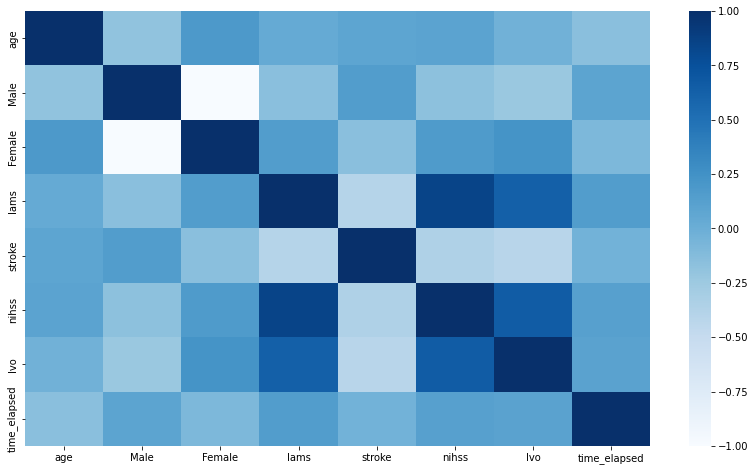

In [9]:
plt.figure(figsize=(14,8))
df_subset = df[['age', 'Male', 'Female', 'lams', 'stroke', 'nihss', 'lvo','time_elapsed']]
corr = df_subset.corr()
heatmap = sns.heatmap(corr, cmap="Blues")
plt.show()

In [10]:
# Select the features that are available onsite
# Select gender for now (until discover 0 is for male or female)
onsite_features = ['age', 'gender', 'lams', 'nihss', 'lvo','time_elapsed']
df_onsite = df[onsite_features]


In [11]:
# Information about the data (onsite)
# data_count = pd.DataFrame(df_onsite.count()).T.rename({0:'total data'})
# data_null = pd.DataFrame(df_onsite.isna().sum()).T.rename({0:'total null'})
# data_null_percentage = pd.DataFrame(100*df_onsite.isna().sum()/df_onsite.shape[0]).T.rename({0:'percentage null'})
# data_info = pd.concat([data_count, data_null, data_null_percentage.round(2)], axis=0)
# data_info
df_onsite.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 0 to 114
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           114 non-null    float64
 1   gender        114 non-null    float64
 2   lams          114 non-null    float64
 3   nihss         114 non-null    float64
 4   lvo           114 non-null    int64  
 5   time_elapsed  114 non-null    int64  
dtypes: float64(4), int64(2)
memory usage: 6.2 KB


There are 16 missing values for stroke variable. We can use either mean/median or simple decision tree to impute the missing values

In [12]:
# Check the duplication in our onsite dataset
df_onsite.duplicated().sum()

0

In [13]:
fig = ex.pie(df_onsite,names='lvo')
fig.update_layout(title='<b>Proportion Of LVO Samples<b>')
fig.show()

We note the dataset is imbalanced. We can deal with this problem using upscaling

In [14]:
# Check the balance of the categorical data
for col in onsite_features:
  pmf_data = Pmf.from_seq(df_onsite[col], normalize=True)
  pmf_data = pd.DataFrame({col:pmf_data.index, 'pmf':pmf_data.values})
  pmf_data.set_index(col, inplace=True)
  display(pmf_data.style.background_gradient(vmin=0, subset='pmf'))

,pmf
age,
22.000000,0.008772
26.000000,0.008772
33.000000,0.008772
38.000000,0.008772
41.000000,0.017544
44.000000,0.008772
47.000000,0.017544
49.000000,0.008772
50.000000,0.017544


,pmf
gender,
1.000000,0.543860
2.000000,0.456140


,pmf
lams,
0.000000,0.350877
1.000000,0.166667
2.000000,0.122807
3.000000,0.122807
4.000000,0.078947
5.000000,0.157895


,pmf
nihss,
0.000000,0.070175
1.000000,0.131579
2.000000,0.052632
3.000000,0.078947
4.000000,0.131579
5.000000,0.096491
6.000000,0.017544
7.000000,0.052632
8.000000,0.061404


,pmf
lvo,
0,0.640351
1,0.359649


,pmf
time_elapsed,
5,0.017544
29,0.008772
30,0.008772
31,0.008772
32,0.008772
34,0.017544
38,0.008772
39,0.008772
40,0.008772


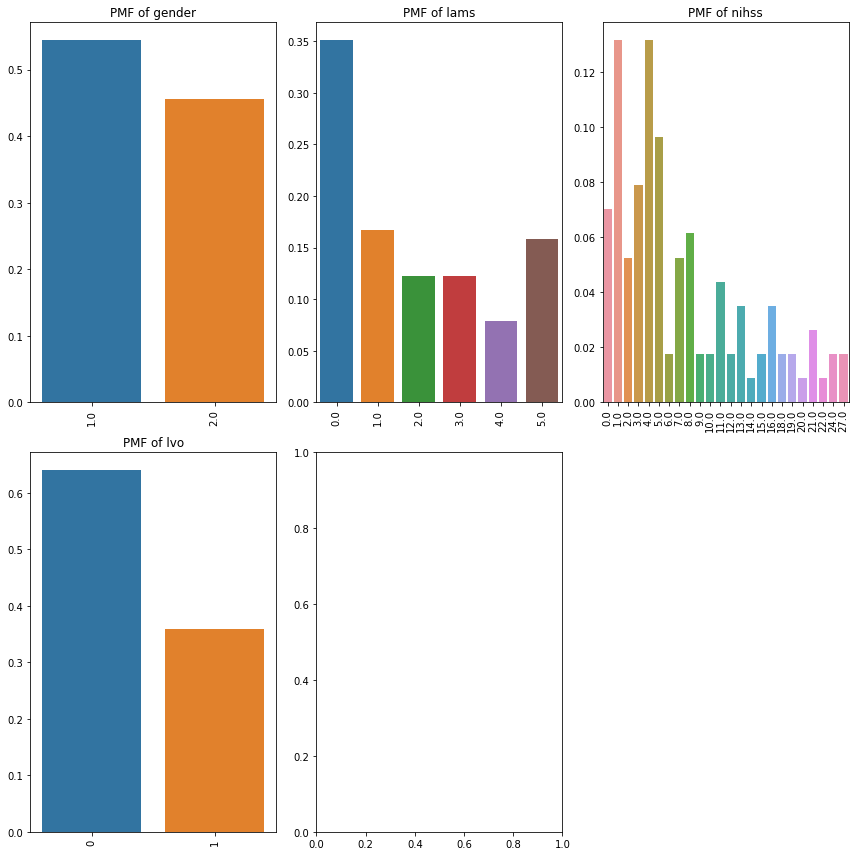

In [15]:
# Plot the balance of the categorical data
categorical_onsite_features = onsite_features[1:5]
fig, ax = plt.subplots(2, 3, figsize=(12,12))
axes_list = [axes for axes_row in ax for axes in axes_row]

for i, col in enumerate(categorical_onsite_features):
  pmf_data = Pmf.from_seq(df_onsite[col], normalize=True)
  pmf_data = pd.DataFrame({col:pmf_data.index, 'pmf':pmf_data})

  sns.barplot(data=pmf_data, x=col, y='pmf', ax=axes_list[i])
  axes_list[i].set_title(f'PMF of {col}')
  axes_list[i].set_xlabel('')
  axes_list[i].set_ylabel('')
  plt.setp(axes_list[i].get_xticklabels(), rotation='vertical')

axes_list[-1].set_visible(False)
plt.tight_layout()
plt.show()

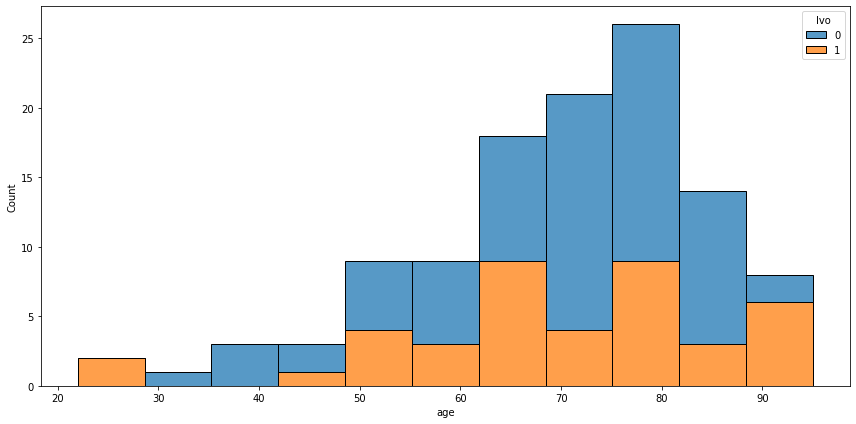

In [16]:
# Plot the distribution of the numerical data
numerical_onsite_features = [onsite_features[0]]
fig, ax = plt.subplots(1, 1, figsize=(12,6))

for i, col in enumerate(numerical_onsite_features):
  # sns.histplot(data=df_onsite, x=col, hue='LVO (incl. M2)', multiple='stack', ax=ax[i])
  sns.histplot(data=df_onsite, x=col, hue='lvo', multiple='stack')

plt.tight_layout()
plt.show()

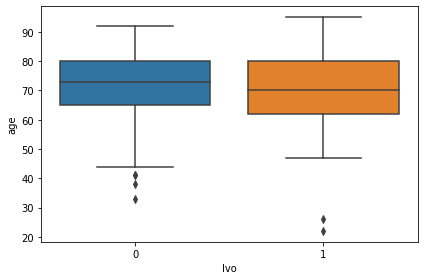

In [17]:
# Plot boxplot to obtain any outliers in numerical data
for i, col in enumerate(numerical_onsite_features):
  sns.boxplot(data=df_onsite, x='lvo', y=col)

plt.tight_layout()
plt.show()

In [20]:
# Upsampling to reduce the imbalanced dataset
oversample = SMOTE()
eval_df = df_onsite[['age', 'gender', 'lams', 'nihss', 'lvo','time_elapsed']].sample(int(df_onsite.shape[0]*0.2),random_state=42)
train_df = df_onsite.drop(index=eval_df.index)

X_eval,y_eval = eval_df[['age', 'gender', 'lams', 'nihss','time_elapsed']], eval_df['lvo']
X,y = train_df[['age', 'gender', 'lams', 'nihss', 'time_elapsed']], train_df['lvo']


X, y = oversample.fit_resample(X,y)
usampled_df = X.assign(lvo = y)

X_eval,y_eval = oversample.fit_resample(X_eval,y_eval)
usampled_eval_df = X_eval.assign(lvo = y_eval)

In [22]:
fig = ex.pie(usampled_df,names='lvo')
fig.update_layout(title='<b>Stroke Proportion After SMOTE Upsampling<b>')
fig.show()

In [23]:
DT_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',DecisionTreeClassifier(random_state=42))])
RF_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',RandomForestClassifier(random_state=42))])
SVM_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',SVC(random_state=42))])
LR_PIPE = Pipeline(steps = [('scale',StandardScaler()),('DT',LogisticRegression(random_state=42))])

X = usampled_df.iloc[:,:-1]
Y = usampled_df.iloc[:,-1]

X_EVAL = usampled_eval_df.iloc[:,:-1]
Y_EVAL = usampled_eval_df.iloc[:,-1]

holdout_x = X.sample(100)
holdout_y = Y.loc[X.index]

X = X.drop(index=holdout_x.index)
Y = Y.drop(index=holdout_x.index)

In [24]:
DT_CROSS_VAL = cross_val_score(DT_PIPE,X,Y,cv=5,scoring='accuracy')
RF_CROSS_VAL = cross_val_score(RF_PIPE,X,Y,cv=5,scoring='accuracy')
SVM_CROSS_VAL = cross_val_score(SVM_PIPE,X,Y,cv=5,scoring='accuracy')
LR_CROSS_VAL = cross_val_score(LR_PIPE,X,Y,cv=5,scoring='accuracy')

In [25]:
fig = make_subplots(rows=4, cols=1,shared_xaxes=True,subplot_titles=('Decision Tree Cross Val Scores',
                                                                     'RandomForest Cross Val Scores',
                                                                    'SVM Cross Val Scores','Logistic Regression Cross Val Scores'))

fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=DT_CROSS_VAL,name='Decision Tree'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=RF_CROSS_VAL,name='RandomForest'),
    row=2, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=SVM_CROSS_VAL,name='SVM'),
    row=3, col=1
)
fig.add_trace(
    go.Scatter(x=list(range(0,len(DT_CROSS_VAL))),y=LR_CROSS_VAL,name='Logistic Regression'),
    row=4, col=1
)

fig.update_layout(height=700, width=900, title_text="Different Model 5 Fold Cross Validation")
fig.update_yaxes(title_text="Accuracy")
fig.update_xaxes(title_text="Fold #")

fig.show()

In [26]:
DT_PIPE.fit(X,Y)
RF_PIPE.fit(X,Y)
SVM_PIPE.fit(X,Y)
LR_PIPE.fit(X,Y)

X = df_onsite.loc[:,X.columns]
Y = df_onsite.loc[:,'lvo']

DT_PRED   = DT_PIPE.predict(X_EVAL)
RF_PRED   =RF_PIPE.predict(X_EVAL)
SVM_PRED  = SVM_PIPE.predict(X_EVAL)
LR_PRED   = LR_PIPE.predict(X_EVAL)

DT_CM  = confusion_matrix(Y_EVAL,DT_PRED )
RF_CM  = confusion_matrix(Y_EVAL,RF_PRED )
SVM_CM = confusion_matrix(Y_EVAL,SVM_PRED)
LR_CM  = confusion_matrix(Y_EVAL,LR_PRED )

DT_F1  = accuracy_score(Y_EVAL,DT_PRED )
RF_F1  = accuracy_score(Y_EVAL,RF_PRED )
SVM_F1 = accuracy_score(Y_EVAL,SVM_PRED)
LR_F1  = accuracy_score(Y_EVAL,LR_PRED )

In [27]:
fig = go.Figure()
fig.add_trace(go.Bar(x=X.columns,y=RF_PIPE['DT'].feature_importances_))
fig.update_layout(title='The Importance Of The Original Attributes On Our Prediction',xaxis_title='Model',yaxis_title='Accuracy')
fig.show()